In [1]:
# https://developers.google.com/optimization/introduction/python
# to do: 
# all or nothing flow - maximum one inflow and one outflow only
# prune variables for the model (so that it is not 100k variables)
# plotting - reduce clutter

In [2]:
%reset -sf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

# Define problem

In [3]:
df = pd.read_pickle("../preprocessing/processed_dataframe.pkl")
# df

In [4]:
for i,row in df.iterrows():
    if len(row["adjacent"]) != len(row["shared_param"]): print(i)

In [5]:
nodes = pd.DataFrame()
nodes["supplies"] = [max(0,z) for z in list(df["TOTAL"])]
nodes["x"] = df["x_centre"]
nodes["y"] = df["y_centre"]

start_nodes = []
end_nodes   = []
unit_costs  = []
for i,row in df.iterrows():
    for adj, cst in zip(row["adjacent"], row["shared_param"]):
        start_nodes.append(i)
        end_nodes.append(adj)
        unit_costs.append(np.around(cst,10))

edges = pd.DataFrame()
edges["start_nodes"] = start_nodes
edges["end_nodes"]   = end_nodes
edges["unit_costs"]  = unit_costs
edges["capacities"]  = [9999999]*len(start_nodes) # disabled
edges["flows"]       = [0]*len(start_nodes)
edges["flowing"]     = [0]*len(start_nodes)
edges["names"]       = "x"+edges[["start_nodes",
                                  "end_nodes"]].astype(str).apply('-'.join, axis=1)
edges.index = edges["names"]
N = len(nodes) # the number of nodes at init

In [6]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x197-175,197,175,0.015639,9999999,0,0,x197-175
x235-226,235,226,0.003761,9999999,0,0,x235-226
x91-49,91,49,0.011640,9999999,0,0,x91-49
x245-244,245,244,0.004019,9999999,0,0,x245-244
x8-14,8,14,0.006419,9999999,0,0,x8-14


# Augment nodes to a common sink

In [7]:
def augment_nodes(nodes, edges):
    for i,ss in enumerate(nodes["supplies"]):
        edges.loc[len(edges)] = [i, len(nodes), 0, 9999999, 0, 0,
                                 "x"+str(i)+"-"+str(len(nodes))]
    nodes.loc[len(nodes)] = [-sum(nodes["supplies"]), 103.7, 1.1]
    edges.index = edges["names"]
    return nodes, edges

In [8]:
nodes, edges = augment_nodes(nodes, edges)
assert sum(nodes["supplies"]) == 0
# nodes
# edges

# Generate adjacency matrix

In [9]:
def get_adjacency_matrix(edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    flowing = edges["flowing"]
    names = edges["names"]
    
    matrix_unit_costs = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_capacities = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flows      = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_flowing    = [[0 for _ in range(N+1)] for _ in range(N+1)]
    matrix_names      = [["x"+str(i)+"-"+str(j)
                          for i in range(N+1)] 
                         for j in range(N+1)]
    
    for x,y,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g
        
    for y,x,z,c,f,g in zip(start_nodes, end_nodes, unit_costs, capacities, flows, flowing):
        matrix_unit_costs[x][y] = z
        matrix_capacities[x][y] = c
        matrix_flows     [x][y] = f
        matrix_flowing   [x][y] = g

    return matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names, matrix_flowing

(matrix_unit_costs, matrix_capacities, 
 matrix_flows, matrix_names, matrix_flowing) = get_adjacency_matrix(edges)

In [10]:
# matrix_unit_costs, matrix_capacities, matrix_flows, matrix_names
assert np.all(np.array(matrix_capacities) == np.transpose(matrix_capacities))
assert np.all(np.array(matrix_unit_costs)[:N,:N] == np.transpose(matrix_unit_costs)[:N,:N])

# Visualisation

In [11]:
edges.sample(5)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x229-223,229,223,0.007014,9999999,0,0,x229-223
x74-127,74,127,0.006817,9999999,0,0,x74-127
x43-318,43,318,0.000000,9999999,0,0,x43-318
x197-147,197,147,0.007714,9999999,0,0,x197-147
x123-62,123,62,0.005332,9999999,0,0,x123-62


In [12]:
def plot_graph(nodes, edges):
    start_nodes = edges["start_nodes"]
    end_nodes = edges["end_nodes"]
    unit_costs = edges["unit_costs"]
    capacities = edges["capacities"]
    flows = edges["flows"]
    names = edges["names"]

    G = nx.DiGraph()
    for x,y,z,c,f,n in zip(start_nodes, end_nodes, unit_costs, capacities, flows, names):
        G.add_edge(x, y, cost=z, capacity=c, flow=f, name=n)

    labeldict = {}
    for i,s in enumerate(nodes["supplies"]):
        labeldict[i] = int(s)

    fig, ax = plt.subplots(figsize=(14,14))
    
    pos=nx.circular_layout(G)
    pos={}
    for i,node in nodes.iterrows():
        pos[i] = [node["x"], node["y"]]
    
    for edge in G.edges(data=True):
        w = edge[2]['flow']
        if w > 0:
            size = np.log(1+w)
            nx.draw_networkx_edge_labels(G,pos, edgelist=[(edge[0],edge[1])], 
                                         edge_labels = {(edge[0],edge[1]): w})
            nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], 
                                   width=size, arrowsize=size*10)
            
    nx.draw_networkx_nodes(G, pos, with_labels=True, font_size=15, 
                           node_size=200, 
                           node_color="yellow")
    nx.draw_networkx_labels(G, pos, labels=labeldict)
    
    ax.autoscale()
    ax.set_aspect(1)
    ax.margins(0.1)
    plt.show()

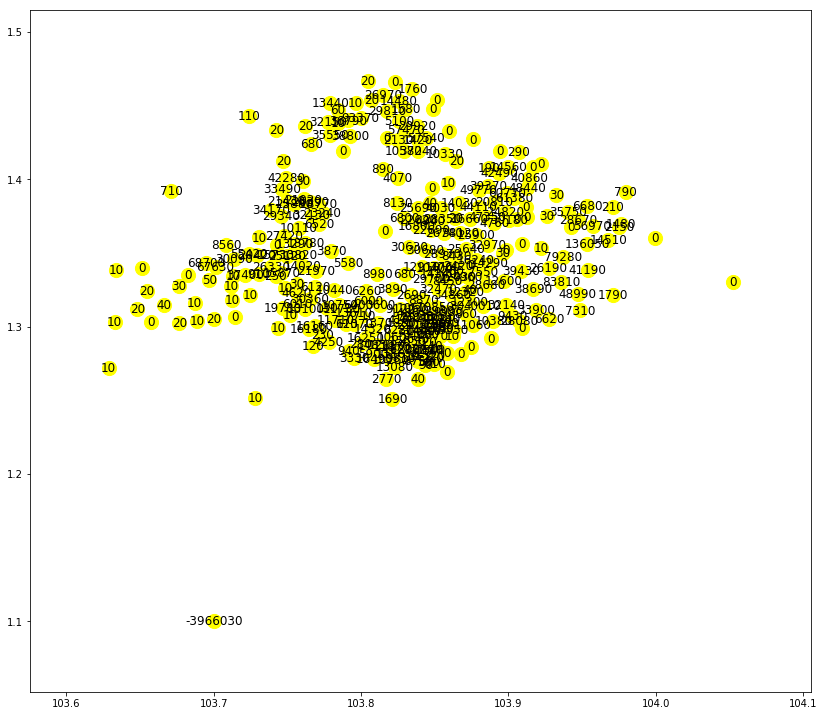

In [13]:
plt.show()
plot_graph(nodes, edges)

# Min-cost flow as a linear program

In [14]:
solver = pywraplp.Solver('hello_program',
                         pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# define variables and capacities
infinity = solver.infinity()
X = [[solver.NumVar(0.0, matrix_capacities[i][j], 'x'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]

# define supplies
for i in range(N+1):
    solver.Add(sum([X[i][j] for j in range(N+1)])
             - sum([X[j][i] for j in range(N+1)])
            == nodes["supplies"][i])

In [15]:
B = [[solver.IntVar(0.0, 1.0, 'b'+str(i)+"-"+str(j)) 
      for j in range(N+1)]
     for i in range(N+1)]

In [16]:
%%time
for i in range(N+1):
    for j in range(N+1):
        if matrix_capacities[i][j] > 0:
            solver.Add(X[i][j] <= 12000000*B[i][j])
#     solver.Add(sum([B[i][j] for j in range(N+1)]) == 1)
#     solver.Add(sum([B[j][i] for j in range(N+1)]) <= 100) # does not work "NOT_SOLVED"

CPU times: user 65.8 ms, sys: 2.5 ms, total: 68.3 ms
Wall time: 67.4 ms


In [17]:
# limit number of cstcs
# solver.Add(sum([B[i][N] for i in range(N)]) <= 10) # what I want to do

# K = 80
# solver.Add(sum(B[i][N] for i in range(K)) <= 50)
# solver.Add(sum(B[N-i][N] for i in range(K)) <= 50)
# solver.Add(sum(B[N//2+i][N] for i in range(-50//2,50//2)) <= 30)

In [18]:
# define objective
solver.Minimize(sum([sum([matrix_unit_costs[i][j] * X[i][j]
                          for j in range(N+1)])
                     for i in range(N+1)])
                + 1*sum([B[i][N] for i in range(N+1)])
)
solver.set_time_limit(10*1000)

print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())

Number of variables = 203522
Number of constraints = 2625


In [19]:
# print(solver.ExportModelAsLpFormat(False).replace('\\', '').replace(',_', ','), sep='\n')

In [20]:
%%time
status = solver.Solve()

CPU times: user 4.05 s, sys: 324 ms, total: 4.37 s
Wall time: 4.39 s


# Visualise output

In [21]:
print('NOT_SOLVED: ', status == pywraplp.Solver.NOT_SOLVED)
print('Stopped by time limit: ', status == pywraplp.Solver.FEASIBLE)
print('Optimal: ', status == pywraplp.Solver.OPTIMAL)
print('Infeasible: ', status == pywraplp.Solver.INFEASIBLE)

NOT_SOLVED:  False
Stopped by time limit:  False
Optimal:  False
Infeasible:  True


In [22]:
print('Solution:')
print('Objective value =', solver.Objective().Value())
print('')
print('Advanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations'   % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())
print(sum(B[i][N].solution_value() for i in range(N+1)))

Solution:
Objective value = 0.0

Advanced usage:
Problem solved in 7211.000000 milliseconds
Problem solved in 708 iterations
Problem solved in 158 branch-and-bound nodes
0.0


In [23]:
matrix_flows = [[x.solution_value() for x in xxx] for xxx in X]
matrix_flowing = [[b.solution_value() for b in bbb] for bbb in B]
for i,row in enumerate(matrix_flows):
    for j,cell in enumerate(row):
        if matrix_flows[i][j] > 0:
            edges.at["x"+str(i)+"-"+str(j),"flows"] = matrix_flows[i][j]
            edges.at["x"+str(i)+"-"+str(j),"flowing"] = matrix_flowing[i][j]

# Visualisation of results

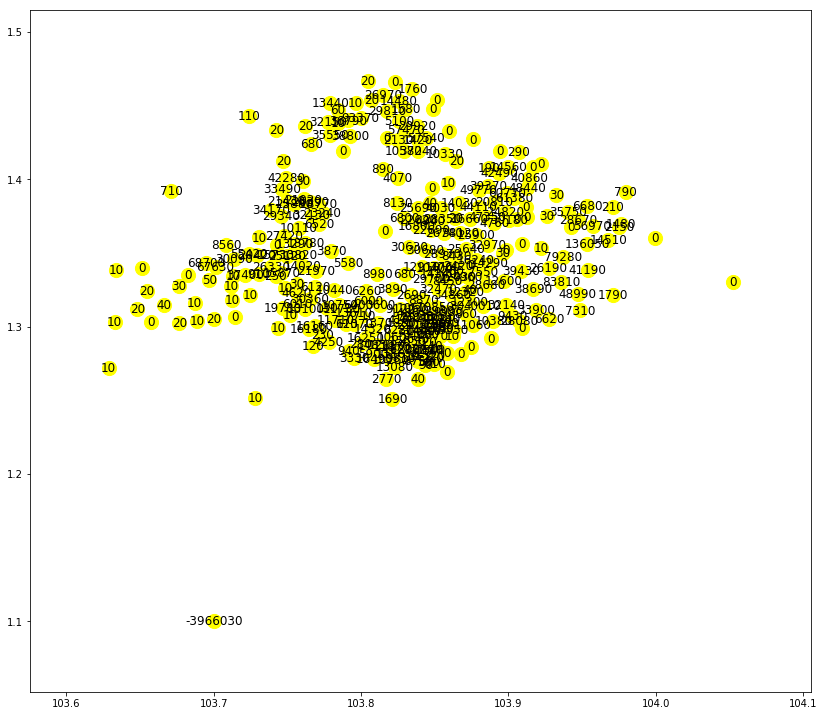

In [24]:
plot_graph(nodes, edges)

In [25]:
edges.tail(10)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x308-318,308,318,0.0,9999999,0,0,x308-318
x309-318,309,318,0.0,9999999,0,0,x309-318
x310-318,310,318,0.0,9999999,0,0,x310-318
x311-318,311,318,0.0,9999999,0,0,x311-318
x312-318,312,318,0.0,9999999,0,0,x312-318
x313-318,313,318,0.0,9999999,0,0,x313-318
x314-318,314,318,0.0,9999999,0,0,x314-318
x315-318,315,318,0.0,9999999,0,0,x315-318
x316-318,316,318,0.0,9999999,0,0,x316-318


In [26]:
edges.tail(318).head(10)

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,
x0-318,0,318,0.0,9999999,0,0,x0-318
x1-318,1,318,0.0,9999999,0,0,x1-318
x2-318,2,318,0.0,9999999,0,0,x2-318
x3-318,3,318,0.0,9999999,0,0,x3-318
x4-318,4,318,0.0,9999999,0,0,x4-318
x5-318,5,318,0.0,9999999,0,0,x5-318
x6-318,6,318,0.0,9999999,0,0,x6-318
x7-318,7,318,0.0,9999999,0,0,x7-318
x8-318,8,318,0.0,9999999,0,0,x8-318


In [27]:
edges[edges["flows"]>0]\
.sort_values(by="start_nodes", ascending=False)\
.sort_values(by="end_nodes", kind='mergesort')

,start_nodes,end_nodes,unit_costs,capacities,flows,flowing,names
names,,,,,,,


0


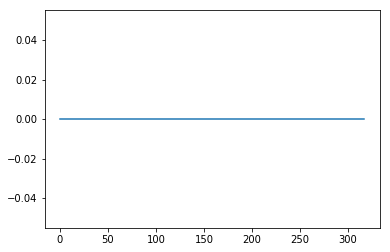

In [28]:
arr = [sum([r > 0 for r in row]) for row in np.transpose(matrix_flows)][:-1]
print(sum(arr))
plt.plot(arr)
plt.show()

0.0


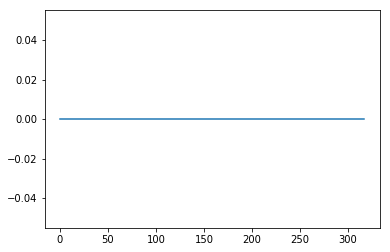

In [29]:
arr = [sum(row) for row in np.transpose(matrix_flowing)][:-1]
print(sum(arr))
plt.plot(arr)
plt.show()

0


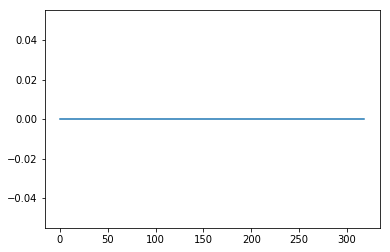

In [30]:
arr = [sum([r > 0 for r in row]) for row in matrix_flows]
print(sum(arr))
plt.plot(arr)
plt.show()

0.0
0.0


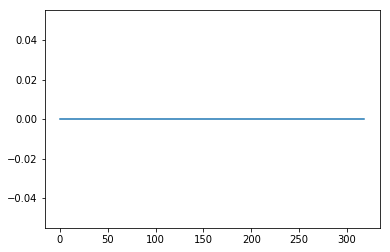

In [31]:
arr = [sum(row) for row in matrix_flowing]
print(arr[-1])
print(sum(arr))
plt.plot(arr)
plt.show()

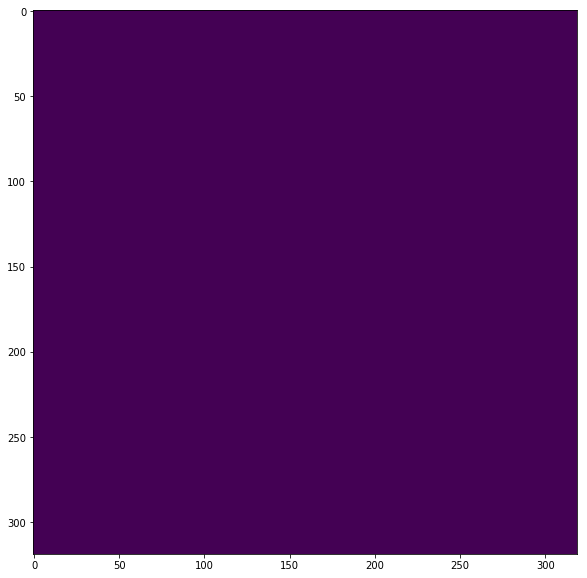

In [32]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.imshow(np.array(matrix_flows)+1,
           norm=LogNorm(vmin=1, vmax=np.sqrt(1+np.max(matrix_flows))))
plt.show()

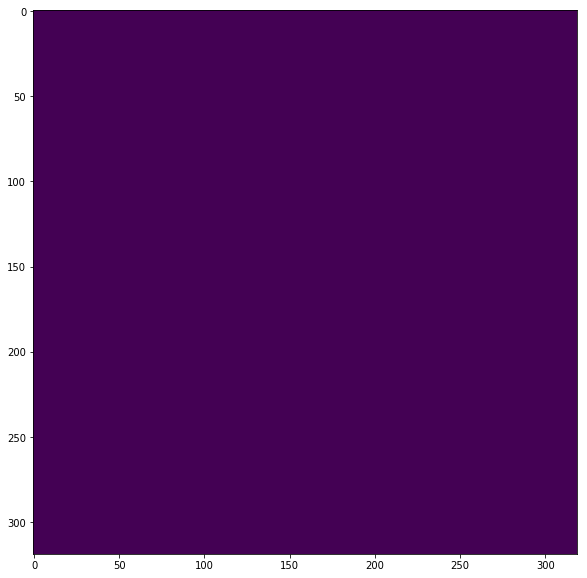

In [33]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.imshow(matrix_flowing)
plt.show()